## Execute localy for DEV

In [ ]:
# Only for the development purposes
# Autosync with updated files
%load_ext autoreload
%autoreload 2

## Execute in Colab environment

In [1]:
# Disable wandb's Jupyter integration BEFORE importing wandb
import os
os.environ["WANDB_DISABLE_CODE"] = "true"
os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_NOTEBOOK_NAME"] = "nowandb"
os.environ["WANDB_RUN_GROUP"] = "nowandb"

# Completely block W&B from installing notebook hooks
import wandb
wandb._jupyter = False

print("WandB notebook hooks disabled.")


WandB notebook hooks disabled.


In [1]:
# Execute in Colab environment
!git clone https://github.com/CharNoir/DL-BotGuard.git
!cp -r DL-BotGuard/sw/ /content/
!rm -rf DL-BotGuard

Cloning into 'DL-BotGuard'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 134 (delta 41), reused 113 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (134/134), 7.08 MiB | 4.98 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [2]:
%cd /content/
from sw.download_datasets import ensure_all_downloaded
ensure_all_downloaded()

/content
[✓] our_dataset ready
[✓] our_bot_dataset ready
[✓] boun ready


In [3]:
import os
os.chdir("/content/sw")
os.getcwd()

'/content/sw'

In [4]:
RELATIVE_FOLDER = "/content/"

## Imports

In [5]:
import numpy as np
import pandas as pd
import torch

import wandb

from sklearn.metrics import accuracy_score

from config import ConfigLoader
from data_loader import (
    load_folder,
    df_to_sequence_windows,
    split_and_scale_sequence,
)

from models.torch_models import GRUMouseNet

from training.trainer_torch import train_torch

from evaluation.eval_sequence import evaluate_with_thresholds
from evaluation.plots import plot_accuracy, plot_f1, plot_recall, plot_precision, plot_precision_recall_both_classes


In [6]:
BEST_MODEL_PATH = "gru_boun_best.pth"

## Loading dataset

In [7]:
try:
    RELATIVE_FOLDER
except Exception as e:
    RELATIVE_FOLDER = "../"

BASE = os.path.join(RELATIVE_FOLDER, "data/raw/boun-mouse-dynamics-dataset/users")

df_user, _ = load_folder(f"{BASE}/user1/training", label=0)
df_att, _ = load_folder(f"{BASE}/user1/internal_tests", label=1)

boun_df = pd.concat([df_user, df_att], ignore_index=True)

X_boun, y_boun = df_to_sequence_windows(
    boun_df,
    window_size=100,
    step=50,
    feature_cols=["x", "y", "dx", "dy", "dt", "speed"],
)


In [8]:
X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_and_scale_sequence(X_boun, y_boun)

## Setup and run sweep

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def sweep_train_gru(config=None):
    """Single sweep pass for GRUMouseNet."""
    with wandb.init(config=config, project="default"):
        cfg = wandb.config
        model = GRUMouseNet.from_config(cfg, input_dim=X_train.shape[2])

        # Train
        model = train_torch(
            model,
            X_train,
            y_train,
            X_val=X_val,
            y_val=y_val,
            epochs=cfg.epochs,
            batch_size=cfg.batch_size,
            lr=cfg.lr,
            wandb_run=wandb,
            save_best_path=BEST_MODEL_PATH,
        )

        # Validation accuracy
        model.to(device)
        model.eval()
        with torch.no_grad():
            logits = model(torch.tensor(X_val, dtype=torch.float32, device=device))
            y_pred = logits.argmax(dim=1).cpu().numpy()

        val_acc = accuracy_score(y_val, y_pred)
        wandb.log({"val_accuracy": val_acc})


# Sweep configuration
sweep_config_gru = {
    "method": "random",
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        "hidden_dim":    {"values": [32, 64, 128]},
        "num_layers":    {"values": [1, 2]},
        "bidirectional": {"values": [True]},
        "dropout":       {"values": [0.0, 0.1, 0.3]},
        "epochs":        {"values": [10, 15]},
        "batch_size":    {"values": [64, 128]},
        "lr":            {"values": [3e-4, 1e-3, 3e-3]},
    },
}

# Start sweep
sweep_id = wandb.sweep(sweep_config_gru, project="mouse-boun-gru-2")
wandb.finish()
wandb.agent(sweep_id, function=sweep_train_gru, count=20)


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find nowandb.


Create sweep with ID: fsmlcfd7
Sweep URL: https://wandb.ai/char_noir-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem/mouse-boun-gru-2/sweeps/fsmlcfd7
Epoch 1/15: loss=0.6309, val_acc=0.6464542746543884
New best model discovered! Saving to gru_boun_best.pth
Model saved: gru_boun_best.pth
Epoch 2/15: loss=0.6115, val_acc=0.6591174602508545
New best model discovered! Saving to gru_boun_best.pth
Model saved: gru_boun_best.pth
Epoch 3/15: loss=0.6002, val_acc=0.6582894921302795
Epoch 4/15: loss=0.5927, val_acc=0.6637930870056152
New best model discovered! Saving to gru_boun_best.pth
Model saved: gru_boun_best.pth
Epoch 5/15: loss=0.5847, val_acc=0.6553184986114502
Epoch 6/15: loss=0.5774, val_acc=0.6693940758705139
New best model discovered! Saving to gru_boun_best.pth
Model saved: gru_boun_best.pth
Epoch 7/15: loss=0.5711, val_acc=0.6681277751922607
Epoch 8/15: loss=0.5647, val_acc=0.6730956435203552
New best model discovered! Saving to gru_boun_best.pth
Model saved: gru_boun_best.pth
Epoch 

## Evaluate best model

In [10]:
model = GRUMouseNet.load(BEST_MODEL_PATH)

Loaded model from gru_boun_best.pth


In [11]:
probs, results, metrics = evaluate_with_thresholds(
    model,
    X_test,
    y_test,
    thresholds=np.linspace(0.1, 0.9, 9),
)


===== Threshold = 0.10 =====
              precision    recall  f1-score   support

           0      0.816     0.036     0.070      9275
           1      0.646     0.995     0.784     16389

    accuracy                          0.649     25664
   macro avg      0.731     0.516     0.427     25664
weighted avg      0.708     0.649     0.526     25664


===== Threshold = 0.20 =====
              precision    recall  f1-score   support

           0      0.782     0.115     0.201      9275
           1      0.662     0.982     0.791     16389

    accuracy                          0.669     25664
   macro avg      0.722     0.548     0.496     25664
weighted avg      0.706     0.669     0.578     25664


===== Threshold = 0.30 =====
              precision    recall  f1-score   support

           0      0.743     0.256     0.381      9275
           1      0.693     0.950     0.801     16389

    accuracy                          0.699     25664
   macro avg      0.718     0.603     

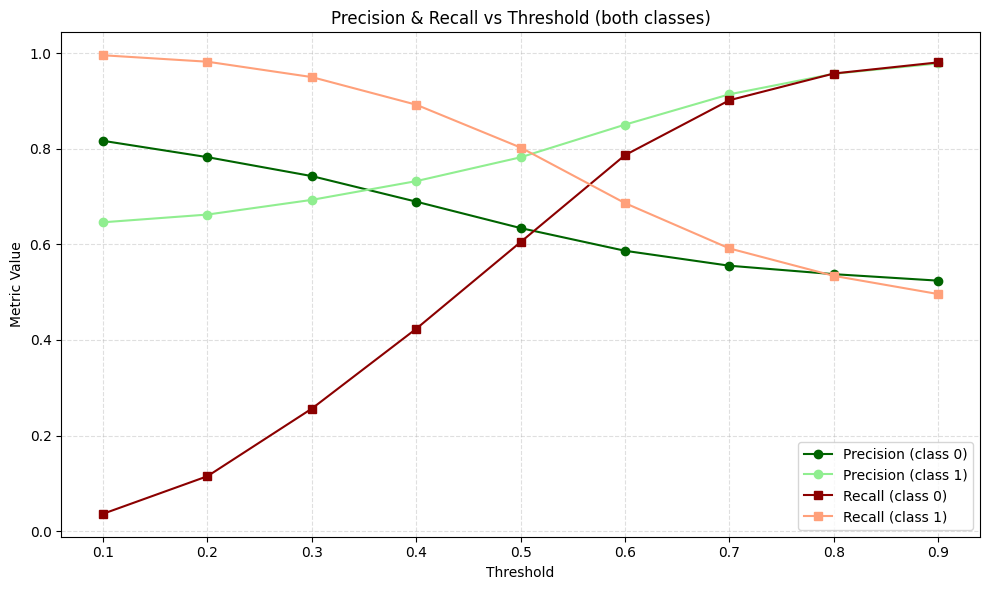

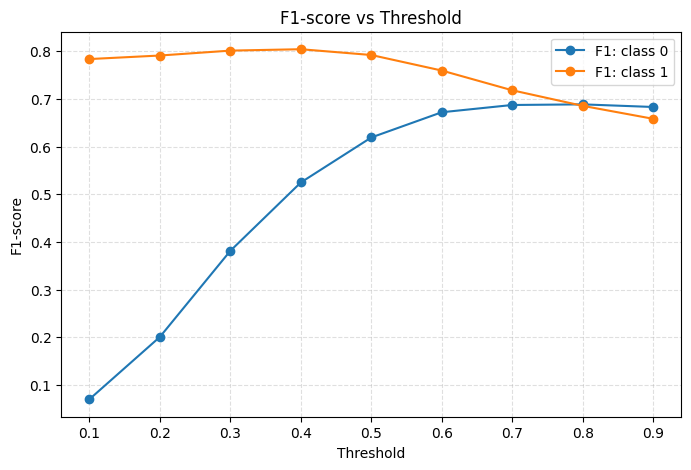

In [12]:
plot_precision_recall_both_classes(metrics)
plot_f1(metrics)